# Aufgabenblatt 1 - Leandro Gregorini

## Inhaltsverzeichnis

* [Aufgabe 2](#Aufgabe2)
* [Aufgabe 3](#Aufgabe3)

## Imports

In [37]:
# deep learning libraries
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
from tensorflow.keras import regularizers

# machine learning libraries
from sklearn.model_selection import train_test_split

# data handling
import numpy as np
import pandas as pd

# visualisierung
%matplotlib inline
import matplotlib.pyplot as plt
import pydot
import graphviz
from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer

TensorFlow version: 2.10.0


---

## Aufgabe 2: MNIST Modell <a class="anchor" id="Aufgabe2"></a>

Folgende Punkte sollen erklärt werden:
- hidden layers
- nodes
- batches
- epochs
- activation function
- regularization
- optimizer

### Datensatz laden und Skalieren

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # Daten laden (direkt in keras integriert)

# Variablen skalieren
x_train, x_test = x_train / 255.0, x_test / 255.0

### Daten plotten

> Mit folgender Funktion können die Daten geplottet werden

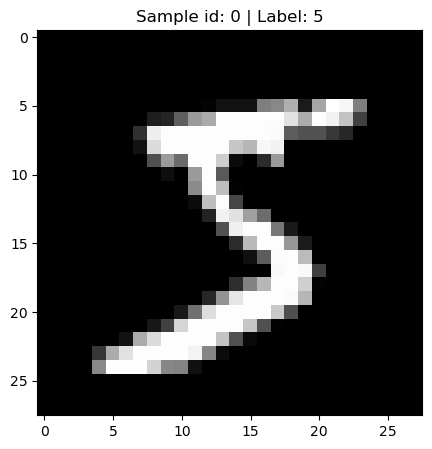

In [3]:
def plot_sample(sample_id, figsize=(5,5)):
    # load sample data
    image = x_train[sample_id]
    label = y_train[sample_id]
    
    # plot the sample
    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(f"Sample id: {sample_id} | Label: {label}")
    plt.show()

plot_sample(sample_id = 0)

> Dieses 28x28 Bild wird anschliessend als Input des Deep Learning Netzwerks verwendet, dabei werden die Insgesamt 784 Pixel jedes Bilds verwendet. <br><br> Jeder Pixel ist codiert mit einer Zahl zwischen 0 (weiss) und 1 (schwarz). Diese Werte werden im Input-Layer eingelesen und gelten dann als "Startwerte" des Deep Learning Netzwerks.

### Analyse der Parameter und Begründungen

- **Hidden Layers**
    - **Beschreibung**: <br>
Die mittlere Schicht bzw. Schichten eines Deep Learning Netzwerks werden als "Hidden Layers" bezeichnet.
Die Neuronen dieser Schichten sind weder "Inputs" noch "Outputs".
Die notwendige Anzahl von Ebenen kann beliebig festgelegt werden und es ist oft schwer die "beste" Anzahl zu finden (oft werden jedoch 2 eingesetzt).
<br><br>
<br> Die gängigsten Fälle die eintreten:
<br>- 0 Hidden Layers: Nur in der Lage linear trennbare Funktionen oder Entscheidungen darzustellen
<br>- 1 Hidden Layer: Kann jede Funktion annähern, die eine kontinuierliche Abbildung von einem endlichen Raum zu einem anderen enthält
<br>- 2 Hidden Layers: Kann mit rationalen Aktivierungsfunktionen eine beliebige Entscheidungsgrenze mit beliebiger Genauigkeit darstellen
    <br><br>
    - **Begründung der Auswahl** <br>
In diesem Modell werden 2 hidden Layer eingesetzt um eine gewisse Komplexität zu erfüllen und dabei die benötigte Rechenleistung in Grenzen zu halten.
<br><br>
- **Nodes**
    - **Beschreibung** <br>
Mit der Anzahl Nodes legt man fest, wie viele Neuronen in den verschiedenen Schichten eingesetzt werden. Die Input-Nodes ergeben sich aus der Problemstellung, im Fall vom MNIST Datensatz sind es 784 Neuronen (28x28), diese Zahl wird durch die Anzahl Pixel der Bilder vorgegeben. Die Output-Nodes werden ebenfalls auf die Problemstellung angepasst, im Fall vom MNIST Datensatz sind es 10 Neuronen, da man eine Zahl zwischen 0 und 10 vorhersagen möchte.
<br><br>
<br> Die Anzahl Hidden-Nodes können mit folgenden Faustregeln festgelegt werden:
<br>- Die Anzahl der Hidden-Nodes sollte zwischen der Anzahl Nodes im Input- und Output Layer liegen
<br>- Die Anzahl der Hidden-Nodes sollte 2/3 der Anzahl Nodes im Input Layer plus der Anzahl Nodes im Output Layer sein
<br>- Die Anzahl der Hidden-Nodes sollte weniger als die doppelte Anzahl an Nodes im Input Layer sein.
    <br><br>
    - **Begründung der Auswahl** <br>
Input- und Output-Nodes werden so gewählt wie oben beschrieben: 784 und 10, zusätzlich werden jeweils 128 Hidden-Nodes verwendet um eine gewisse Komlexität zu erreichen.
<br><br>
- **Batches**
    - **Beschreibung** <br>
Die batch size definiert die Anzahl an Trainingsdaten, die durch das Netzwerk in einer "Iteration" weitergegeben werden.
<br><br>
Vorteile für das Verwenden einer batch size < Anzahl aller Trainingsdaten:
<br>- Es erfordert weniger Speicher
<br>- Typischerweise trainieren Netzwerke mit Mini-Batches schneller.
<br>
Nachteile:
<br>- Umso kleiner der Batch ist, desto ungenauer wird die Schätzung des Gradienten sein. 
<br><br> Folgende Batch sizes können je nach Hardware eingesetzt werden:
<br>- 1, 2, 4, 8, 16 - eher lange Trainingszeit
<br>- 32 oder 64 - Beim Rechnen mit CPU
<br>- 128 oder 256 - Beim Rechnen mit GPU
    <br><br>
    - **Begründung der Auswahl** <br>
Um die Rechenleistung in Grenzen zu halten werden die Daten vorerst in Batches der Grösse 16 unterteilt.
<br><br>
- **Epochs**
    - **Beschreibung** <br>
Ein kompletter Durchlauf aller Input-Daten wird als Epoche bezeichnet. Dabei können die Input-Daten je nach Größe des Datensatzes auch in gleich große Gruppen (Batches) eingeteilt werden und das Training kann jeweils pro Batch durchgeführt werden.
    <br><br>
    - **Begründung der Auswahl** <br>
Das Model wird mit 10 Epochen trainiert und kann später erhöht werden um eventuell noch genauere Ergebnisse zu erhalten.
<br><br>
- **Activation function**
    - **Beschreibung** <br>
Die Wahl der Aktivierungsfunktion im Hidden Layer bestimmt, wie gut das Modell den Trainingsdatensatz erlernt.
<br><br>
Folgende Funktionen gibt es für die Hidden Layers:
<br>- Rectified Linear Activation (ReLU)
<br>- Logistic (Sigmoid)
<br>- Hyperbolic Tangent (Tanh)
<br><br>
Folgende Funktionen gibt es für den Output Layer:
<br>- Regression: linear
<br>- Klassifikation: softmax oder sigmoid (sollte nur verwendet werden, wenn mehrere Outputs als "richtige" Antworten gelten sollen)
    <br><br>
    - **Begründung der Auswahl** <br>
Für das Modell wird ReLU verwendet da diese Aktivierungsfunktion am besten funktioniert, wenn die Input Daten in einer Range von 0 bis 1 skaliert sind, was bei uns mit dem MNIST-Datensatz der Fall ist. Für die Funktion im Output Layer wird softmax verwendet, da es sich um eine Klassifikation handelt.
<br><br>
- **Regularization**
    - **Beschreibung** <br>
Mit Regularisierung möchte man Overfitting in neuronalen Netzen reduzieren und somit die Genauigkeit eines Deep Learning Modells bei Anwendung auf komplett neue Daten verbessern.
<br><br>
Es gibt verschiedene Arten der Regularisierung:
<br>- L1-Regularisierung: Kann als eine Art Neuronenselektion betrachtet werden, da sie die Gewichte einiger versteckter Neuronen auf Null bringt.
<br>- L2-Regularisierung: Die Werte der Gewichte werden gegen Null gebracht, was zu einem einfacheren Modell führt.
<br>- Dropout: Die Idee der Dropout-Regularisierung besteht darin, einige Knoten nach dem Zufallsprinzip zu entfernen. Wie bei der L2-Regularisierung vereinfacht sich das Modell und die Komplexität wird somit reduziert.
    <br><br>
    - **Begründung der Auswahl** <br>
Es wird ein kleiner Dropout von 0.05 verwendet um Overfitting etwas zu minimieren.
<br><br>
- **Optimizer**
    - **Beschreibung** <br>
Optimizer sind Algorithmen oder Methoden, die zur Minimierung einer Fehlerfunktion (Verlustfunktion) oder zur Maximierung der Effizienz eingesetzt werden (Oft "Gradient descent"). Optimizer sind mathematische Funktionen, die von den Parametern des Modells abhängen, d.h. von den weights und biases.
<br> Im Keras Paket gibt es viele Optimizer, welche verwendet werden können, diese sind in der <a href="https://keras.io/api/optimizers/">Dokumentation</a> genauer beschrieben.
<br><br>
Grobe Übersicht:
<br>- Gradient Descent: Batch gradient descent, stochastic gradient descent, mini-batch gradient descent
<br>- Adaptive: Adagrad, Adadelta, RMSprop, Adam
    <br><br>
    - **Begründung der Auswahl** <br>
Laut gewissen Tests (siehe Referenzen unten im Dokument) funktioniert für den MNIST Datensatz stochastic gradient descent oder adam am besten. Mit dem Optimizer muss experimentiert werden um das bestmögliche Ergebnis erzielen zu können. 

### Daten vorbereiten

In [4]:
# Variablen umformatieren
x_train = x_train.reshape((len(x_train),28*28))
x_test = x_test.reshape((len(x_test),28*28))

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

# Zielvariable kategorisieren -> jede Nummer als one-hot category
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

print("\ny_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 784)
x_test shape: (10000, 784)

y_train shape: (60000, 10)
y_test shape: (10000, 10)


### Optimizer vorbereiten

In [69]:
# Funktion für Optimizer je nach Auswahl in der Konfiguration
def get_optimizer(optimizer_name, learning_rate):
    #'sgd','rmsprop','adam','adagrad'
    optimizer=None

    if optimizer_name == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)

    elif 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)

    elif 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    return optimizer

### Modell initialisieren

> Code-Snippets aus Kurs CDS-108 (siehe Referenzen unten im Dokument)

In [6]:
# Konfiguration des Models (gespeichert in einem dict)
model_config = {
            "INPUT_SHAPE" : (x_train.shape[1],),                # Form des Inputs (Für MNIST: 28x28 Pixel)
            "HIDDEN_NODES" : [128,128],                         # Anzahl Neuronen im Hidde Layer (Es werden 2 Hidden-Layers eingesetzt)
            "HIDDEN_ACTIVATION" : "relu",                       # Aktivierungsfunktion im Hidden Layer
            "OUTPUT_NODES" : 10,                                # Output nodes des Output Layers
            "OUTPUT_ACTIVATION" : "softmax",
            "WEIGHTS_INITIALIZER" : "random_normal",            # Initialisierung der Gewichte
            "BIAS_INITIALIZER" : "zeros",                       # Initialisierung des Bias
            "NORMALIZATION" : "none",                           # Normalisierung
            "OPTIMIZER" : "adam",
            "LEARNING_RATE" : 0.001,                            # Lernrate für "Gradient descent"
            "REGULARIZER" : None,                               # Regularisierung (L1, L2)
            "DROPOUT_RATE" : 0.05,                              # Regularisierung (Dropout)
            "EPOCHS" : 10,                                      # Anzahl der Epochen, welche trainiert werden sollen
            "BATCH_SIZE" : 16,
            "VALIDATION_SPLIT" : 0.2,                           # Grösse des Validierungs-Datensatzes
            "VERBOSE" : 1,                                      # Bestimmt die Ausgabe von Infos beim Tranieren des Modells (verbose=0: silent, verbose=1: animierte Anzeige, verbose=2: Zeigt nur die Anzahl Epochen an, welche abgearbeitet wurden)
            "LOSS_FUNCTION" : "categorical_crossentropy",       # Kostenfunktion (categorical_crossentropy und binary_crossentropy für Klassifikation und MSE für Regression)
            "METRICS" : ["accuracy"]                            # Optimierungs-Metrik
            }

In [7]:
def prepare_model(model_name, model_config):
    model=tf.keras.models.Sequential(name=model_name)  # Keras Layers in sequentieller Ordnung aufbauen

    for layer in range(len(model_config["HIDDEN_NODES"])):  # Anzahl Hidden Layers
        if layer == 0:
            # Erster Hidden Layer und Input Layer hinzufügen
            model.add(
                    tf.keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    input_shape=model_config["INPUT_SHAPE"],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            # Weitere Hidden Layers hinzufügen
            model.add(
                    tf.keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                    name="Dense-Layer-" + str(layer),
                    kernel_initializer = model_config["WEIGHTS_INITIALIZER"],
                    bias_initializer = model_config["BIAS_INITIALIZER"],
                    kernel_regularizer=model_config["REGULARIZER"],
                    activation=model_config["HIDDEN_ACTIVATION"]))
            
            # Weitere Layers hinzufügen
            if model_config["NORMALIZATION"] == "batch":
                model.add(tf.keras.layers.BatchNormalization())

            if model_config["DROPOUT_RATE"] > 0.0:
                model.add(tf.keras.layers.Dropout(model_config["DROPOUT_RATE"]))
                
    model.add(tf.keras.layers.Dense(model_config["OUTPUT_NODES"],
                    name="Output-Layer",
                    activation=model_config["OUTPUT_ACTIVATION"]))

    optimizer = get_optimizer( model_config["OPTIMIZER"],
                              model_config["LEARNING_RATE"])

    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                   metrics=model_config["METRICS"])
    return model

In [8]:
model = prepare_model(model_name = "MNIST-MODEL", model_config = model_config)  # load/prepare model

### Modell visualisieren

In [9]:
visualizer(model, file_name="MNIST-MODEL", file_format='png')  # visualizer from keras_visualizer package

<img src="MNIST-MODEL.png">

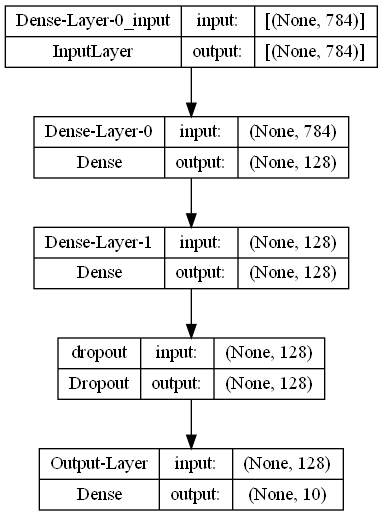

In [10]:
plot_model(model, to_file="MNIST-MODEL_KERAS.png", show_shapes=True, show_layer_names=True)  # visualizer integrated in keras package

### Modell erstellen und trainieren

In [11]:
model.summary()

Model: "MNIST-MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 128)               100480    
                                                                 
 Dense-Layer-1 (Dense)       (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 Output-Layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [12]:
def run_model(model, x_train, y_train, stratify):
    X_train, X_val, Y_train, Y_val = train_test_split(
                            x_train, y_train,
                            stratify=stratify,
                            test_size=model_config["VALIDATION_SPLIT"])

    history=model.fit(X_train,
              Y_train,
              batch_size=model_config["BATCH_SIZE"],
              epochs=model_config["EPOCHS"],
              verbose=model_config["VERBOSE"],
              validation_data= (X_val, Y_val))
    return history, model, X_train, Y_train, X_val, Y_val

In [14]:
history, model, X_train, Y_train, X_val, Y_val = run_model(model=model, x_train=x_train, y_train=y_train, stratify=y_train)  # save trained model and data

Epoch 1/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.2557 - accuracy: 0.9242 - val_loss: 0.1437 - val_accuracy: 0.9577
Epoch 2/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.1290 - accuracy: 0.9645 - val_loss: 0.1309 - val_accuracy: 0.9668
Epoch 3/10
3000/3000 [==============================] - 11s 4ms/step - loss: 0.1031 - accuracy: 0.9739 - val_loss: 0.1201 - val_accuracy: 0.9713
Epoch 4/10
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0896 - accuracy: 0.9785 - val_loss: 0.1436 - val_accuracy: 0.9685
Epoch 5/10
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0849 - accuracy: 0.9809 - val_loss: 0.1245 - val_accuracy: 0.9745
Epoch 6/10
3000/3000 [==============================] - 12s 4ms/step - loss: 0.0802 - accuracy: 0.9825 - val_loss: 0.2399 - val_accuracy: 0.9603
Epoch 7/10
3000/3000 [==============================] - 11s 4ms/step - loss: 0.0738 - accuracy: 0.9835 - val_loss: 0.1747 - val_ac

### Modell evaluieren

> Genauigkeit des Modells ausgeben

In [15]:
def get_score_classification(model, x_data, y_data, verbose=2):
    score=model.evaluate(x_data, y_data, verbose=verbose)
    loss_score = score[0]
    accuracy_score = score[1]
    return loss_score, accuracy_score

print("\n------------------------------------------------------------------------------")
print("Scores")
print("------------------------------------------------------------------------------\n")
print("Train data")
x_train_loss_score, x_train_accuracy_score = get_score_classification(model=model, x_data=X_train, y_data=Y_train)  # store scores
print("x_train loss_score:", x_train_loss_score)
print("x_train accuracy_score:", x_train_accuracy_score)
print("\n------------------------------------------------------------------------------")
print("Test data")
x_test_loss_score, x_test_accuracy_score = get_score_classification(model=model, x_data=x_test, y_data=y_test)  # store scores
print("x_test loss_score:", x_test_loss_score)
print("x_test accuracy_score:", x_test_accuracy_score)
print("\n------------------------------------------------------------------------------")
print("Validation data")
x_val_loss_score, x_val_accuracy_score = get_score_classification(model=model, x_data=X_val, y_data=Y_val)  # store scores
print("x_val loss_score:", x_val_loss_score)
print("x_val accuracy_score:", x_val_accuracy_score)


------------------------------------------------------------------------------
Scores
------------------------------------------------------------------------------

Train data
1500/1500 - 4s - loss: 0.0375 - accuracy: 0.9905 - 4s/epoch - 2ms/step
x_train loss_score: 0.037456776946783066
x_train accuracy_score: 0.9904999732971191

------------------------------------------------------------------------------
Test data
313/313 - 1s - loss: 0.1965 - accuracy: 0.9738 - 624ms/epoch - 2ms/step
x_test loss_score: 0.19652846455574036
x_test accuracy_score: 0.973800003528595

------------------------------------------------------------------------------
Validation data
375/375 - 1s - loss: 0.1694 - accuracy: 0.9745 - 895ms/epoch - 2ms/step
x_val loss_score: 0.16940957307815552
x_val accuracy_score: 0.9745000004768372


> Wie man oben in den Scores sehen kann, performt das Modell ziemlich gut und hat eine Genauigkeit von 97.5% auf den Trainingsdaten.

In [16]:
def plot_measures_classification(model_name, history=history, title="Measures", accuracy_measures_to_plot=["train_loss", "train_accuracy", "val_loss", "val_accuracy"]):
    accuracy_measures={}
    accuracy_measures["train_loss"] = history.history["loss"]
    accuracy_measures["train_accuracy"] = history.history["accuracy"]
    accuracy_measures["val_loss"] = history.history["val_loss"]
    accuracy_measures["val_accuracy"] = history.history["val_accuracy"]
    plt.figure(figsize=(15, 8))
    for measure in accuracy_measures.keys():
        if measure in accuracy_measures_to_plot:
            plt.plot(accuracy_measures[measure], label=measure, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/Loss")
    plt.legend()
    plt.show()

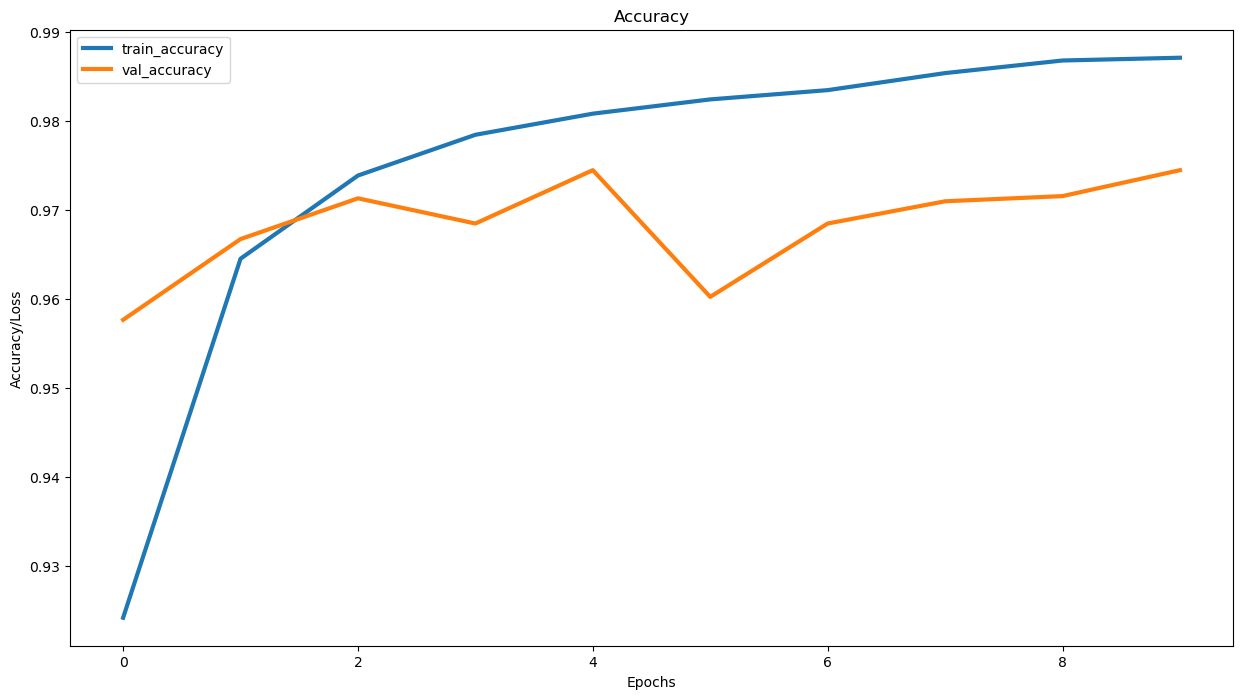

In [17]:
plot_measures_classification(model_name="MNIST-MODEL", history=history, title="Accuracy",accuracy_measures_to_plot=["train_accuracy", "val_accuracy"])

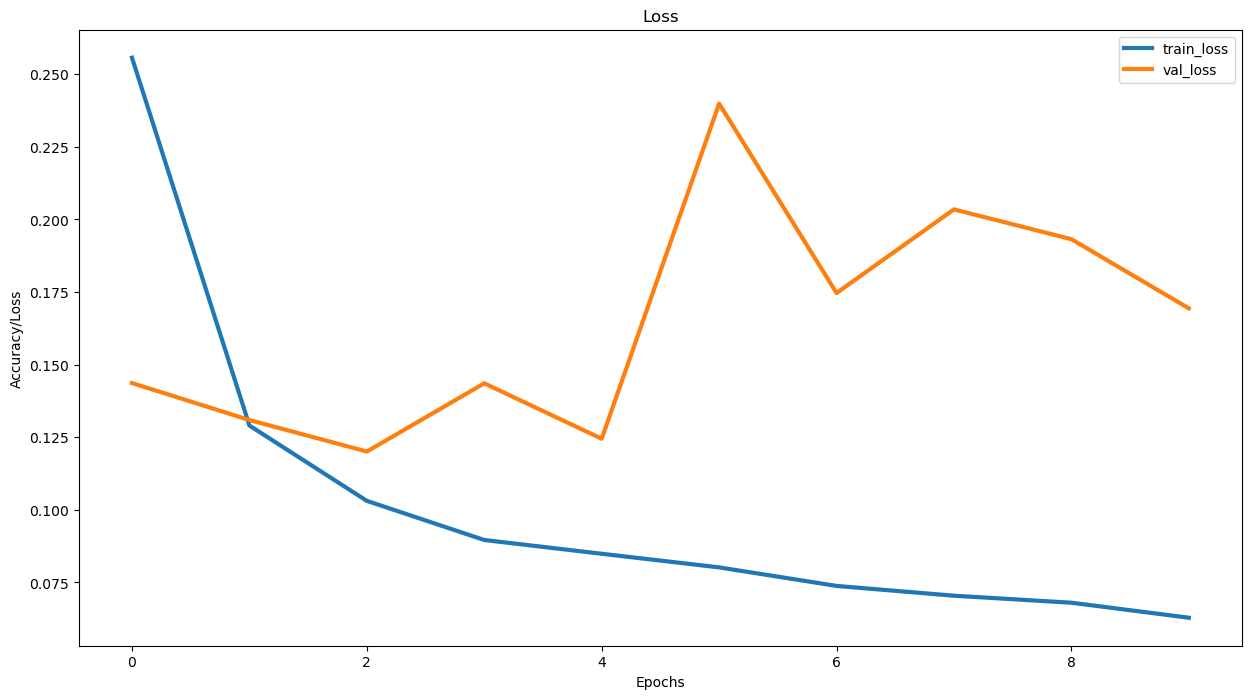

In [19]:
plot_measures_classification(model_name="MNIST-MODEL", history=history, title="Loss", accuracy_measures_to_plot=["train_loss", "val_loss"])

> Da das Modell sowohl auf dem Trainings- und Test-Datensatz/Validierungs-Datensatz gut performt hat und keine grossen Diskrepanzen zu erkennen sind (Plots) sollte kein allzu grosses Overfitting im Modell vorhanden sein obwohl die val_loss im oberen Plot mit zunehmender Anzahl Epochen etwas zunimmt. Mit dem Validierungs-Datensatz und dem Dropout wurde versucht das ganze zu vermindern.

>Weitere Schritte: Man könnte das Modell noch ausbauen mit weiteren Regularisierungen oder Normalisierungen und mehr nodes/layers hinzufügen, da die Ergebnisse jedoch schon so ziemlich gut sind, sollte das Modell für den Anfang genügend gut sein. Durch Hyperparameter Tuning bzw. Optimierung könnte eventuell noch eine grössere Genauigkeit erzielt werden und Overfitting analysiert und gegebenfalls vermindert werden.

---

## Aufgabe 3: Boston Housing <a class="anchor" id="Aufgabe3"></a>

> Code-Snippets und Infos von Kaggle (siehe Referenzen unten im Dokument)

> Es werden gleiche Funktionen eingesetzt wie in Aufgabe 2 bereits verwendet (Die Definitionen der Funktionen wurdenn nicht erneut aufgeführt) 

Dieser Datensatz stammt aus der Immobilienbranche Boston (USA). Die Zielvariable bezieht sich auf den Medianwert von Eigenheimen jeweils in 1000 USD.
<br><br>
Dieses Dataset enthält folgende 14 Attribute:
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per 10,000 USD
- PTRATIO: pupil-teacher ratio by town
- B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: lower status of the population (%)
- MEDV: Median value of owner-occupied homes in 1000 USD's (Target)

**WARNING** from <a href="https://keras.io/api/datasets/boston_housing/">keras API reference</a>:
<br>This dataset has an ethical problem: the authors of this dataset included a variable, "B", that may appear to assume that racial self-segregation influences house prices. As such, we strongly discourage the use of this dataset, unless in the context of illustrating ethical issues in data science and machine learning.

### Datensatz laden

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(test_split=0.2)  # Daten laden (direkt in keras integriert)

In [21]:
print(f'Shape x_train : {x_train.shape}')
print(f'Shape x_test : {x_test.shape}')
print(f'Shape y_train : {y_train.shape}')
print(f'Shape y_test : {y_test.shape}')
print("\n")
print(f'Training sample : {x_train[0]}')
print(f'Training target sample : {y_train[0]}')

Shape x_train : (404, 13)
Shape x_test : (102, 13)
Shape y_train : (404,)
Shape y_test : (102,)


Training sample : [  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
Training target sample : 15.2


### Modell initialisieren

> Code-Snippets aus Kurs CDS-108 (siehe Referenzen unten im Dokument)

In [53]:
# Konfiguration des Models (gespeichert in einem dict)
model_config = {
            "INPUT_SHAPE" : (x_train.shape[1],),                # Form des Inputs (Für Boston Housing: Anzahl features)
            "HIDDEN_NODES" : [10,10],                           # Anzahl Neuronen im Hidde Layer (Es werden 2 Hidden-Layers eingesetzt) wird auf 10 festgelegt -> 2/3 der Anzahl Input Nodes + Anzahl Output Nodes
            "HIDDEN_ACTIVATION" : "relu",                       # Aktivierungsfunktion im Hidden Layer
            "OUTPUT_NODES" : 1,                                 # Output nodes des Output Layers
            "OUTPUT_ACTIVATION" : None,
            "WEIGHTS_INITIALIZER" : "random_normal",            # Initialisierung der Gewichte
            "BIAS_INITIALIZER" : "zeros",                       # Initialisierung des Bias
            "NORMALIZATION" : "none",                           # Normalisierung
            "OPTIMIZER" : "rmsprop",                            # Root Mean Square Propagation
            "LEARNING_RATE" : 0.01,                             # Lernrate für "Gradient descent" (0.01 oder 0.1 meist standard)
            "REGULARIZER" : None,                               # Regularisierung (L1, L2)
            "DROPOUT_RATE" : 0.15,                              # Regularisierung (Dropout)
            "EPOCHS" : 101,                                     # Anzahl der Epochen, welche trainiert werden sollen
            "BATCH_SIZE" : 4,                                   # Anzahl Daten pro batch
            "VALIDATION_SPLIT" : 0.2,                           # Grösse des Validierungs-Datensatzes
            "VERBOSE" : 1,                                      # Bestimmt die Ausgabe von Infos beim Tranieren des Modells (verbose=0: silent, verbose=1: animierte Anzeige, verbose=2: Zeigt nur die Anzahl Epochen an, welche abgearbeitet wurden)
            "LOSS_FUNCTION" : "mse",                            # Kostenfunktion (MSE für Regression)
            "METRICS" : ["RootMeanSquaredError"]                # Optimierungs-Metrik
            }

In [54]:
model = prepare_model(model_name = "BOSTON-HOUSING-MODEL", model_config = model_config)  # load/prepare model

### Modell visualisieren

In [55]:
visualizer(model, file_name="BOSTON-HOUSING-MODEL", file_format='png')  # visualizer from keras_visualizer package

<img src="BOSTON-HOUSING-MODEL.png">

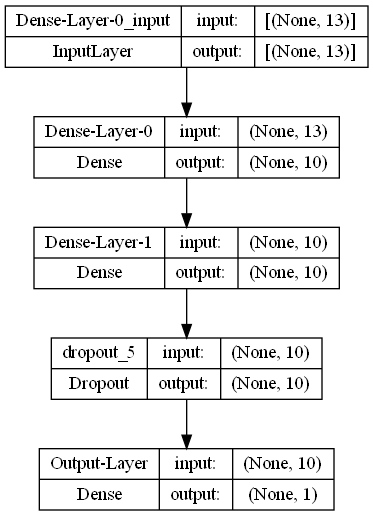

In [56]:
plot_model(model, to_file="BOSTON-HOUSING-MODEL_KERAS.png", show_shapes=True, show_layer_names=True)  # visualizer integrated in keras package

### Modell erstellen und trainieren

In [57]:
model.summary()

Model: "BOSTON-HOUSING-MODEL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 10)                140       
                                                                 
 Dense-Layer-1 (Dense)       (None, 10)                110       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 Output-Layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [58]:
history, model, X_train, Y_train, X_val, Y_val = run_model(model=model, x_train=x_train, y_train=y_train, stratify=None)  # save trained model and data

Epoch 1/101
81/81 [==============================] - 1s 6ms/step - loss: 140.9974 - root_mean_squared_error: 11.8742 - val_loss: 115.7413 - val_root_mean_squared_error: 10.7583
Epoch 2/101
81/81 [==============================] - 0s 3ms/step - loss: 109.2777 - root_mean_squared_error: 10.4536 - val_loss: 80.4842 - val_root_mean_squared_error: 8.9713
Epoch 3/101
81/81 [==============================] - 0s 3ms/step - loss: 95.0726 - root_mean_squared_error: 9.7505 - val_loss: 82.4079 - val_root_mean_squared_error: 9.0779
Epoch 4/101
81/81 [==============================] - 0s 3ms/step - loss: 88.0744 - root_mean_squared_error: 9.3848 - val_loss: 82.6838 - val_root_mean_squared_error: 9.0931
Epoch 5/101
81/81 [==============================] - 0s 4ms/step - loss: 91.4036 - root_mean_squared_error: 9.5605 - val_loss: 76.0895 - val_root_mean_squared_error: 8.7229
Epoch 6/101
81/81 [==============================] - 0s 4ms/step - loss: 79.3801 - root_mean_squared_error: 8.9096 - val_loss: 68

81/81 [==============================] - 0s 4ms/step - loss: 24.3888 - root_mean_squared_error: 4.9385 - val_loss: 56.9453 - val_root_mean_squared_error: 7.5462
Epoch 96/101
81/81 [==============================] - 0s 4ms/step - loss: 24.4558 - root_mean_squared_error: 4.9453 - val_loss: 76.2614 - val_root_mean_squared_error: 8.7328
Epoch 97/101
81/81 [==============================] - 0s 4ms/step - loss: 21.5910 - root_mean_squared_error: 4.6466 - val_loss: 73.3385 - val_root_mean_squared_error: 8.5638
Epoch 98/101
81/81 [==============================] - 0s 3ms/step - loss: 29.0330 - root_mean_squared_error: 5.3882 - val_loss: 41.8778 - val_root_mean_squared_error: 6.4713
Epoch 99/101
81/81 [==============================] - 0s 4ms/step - loss: 24.9897 - root_mean_squared_error: 4.9990 - val_loss: 83.4957 - val_root_mean_squared_error: 9.1376
Epoch 100/101
81/81 [==============================] - 0s 4ms/step - loss: 27.2324 - root_mean_squared_error: 5.2185 - val_loss: 51.4266 - val_

### Modell evaluieren

In [59]:
def get_score_regression(model, x_data, y_data, verbose=2):
    score=model.evaluate(x_data, y_data, verbose=verbose)
    mse_score = score[0]
    mae_score = score[1]
    return mse_score, mae_score

print("\n------------------------------------------------------------------------------")
print("Scores")
print("------------------------------------------------------------------------------\n")
print("Train data")
x_train_mse_score, x_train_mae_score = get_score_regression(model=model, x_data=X_train, y_data=Y_train)  # store scores
print("x_train MSE:", x_train_mse_score)
print("x_train MAE:", x_train_mae_score)
print("\n------------------------------------------------------------------------------")
print("Test data")
x_test_mse_score, x_test_mae_score = get_score_regression(model=model, x_data=x_test, y_data=y_test)  # store scores
print("x_test MSE:", x_test_mse_score)
print("x_test MAE:", x_test_mae_score)
print("\n------------------------------------------------------------------------------")
print("Validation data")
x_val_mse_score, x_val_mae_score = get_score_regression(model=model, x_data=X_val, y_data=Y_val)  # store scores
print("x_val MSE:", x_val_mse_score)
print("x_val MAE:", x_val_mae_score)


------------------------------------------------------------------------------
Scores
------------------------------------------------------------------------------

Train data
11/11 - 0s - loss: 13.0002 - root_mean_squared_error: 3.6056 - 65ms/epoch - 6ms/step
x_train MSE: 13.000211715698242
x_train MAE: 3.6055805683135986

------------------------------------------------------------------------------
Test data
4/4 - 0s - loss: 28.8001 - root_mean_squared_error: 5.3666 - 50ms/epoch - 12ms/step
x_test MSE: 28.800121307373047
x_test MAE: 5.366574287414551

------------------------------------------------------------------------------
Validation data
3/3 - 0s - loss: 59.4362 - root_mean_squared_error: 7.7095 - 52ms/epoch - 17ms/step
x_val MSE: 59.436187744140625
x_val MAE: 7.709486961364746


In [61]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

In [65]:
def plot_measures_regression(model_name, history=history, title="Measures", accuracy_measures_to_plot=["train_loss", "train_root_mean_squared_error", "val_loss", "val_root_mean_squared_error"]):
    accuracy_measures={}
    accuracy_measures["train_loss"] = history.history["loss"]
    accuracy_measures["train_root_mean_squared_error"] = history.history["root_mean_squared_error"]
    accuracy_measures["val_loss"] = history.history["val_loss"]
    accuracy_measures["val_root_mean_squared_error"] = history.history["val_root_mean_squared_error"]
    plt.figure(figsize=(15, 8))
    for measure in accuracy_measures.keys():
        if measure in accuracy_measures_to_plot:
            plt.plot(accuracy_measures[measure], label=measure, linewidth=3)

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("RMSE/Loss")
    plt.legend()
    plt.show()

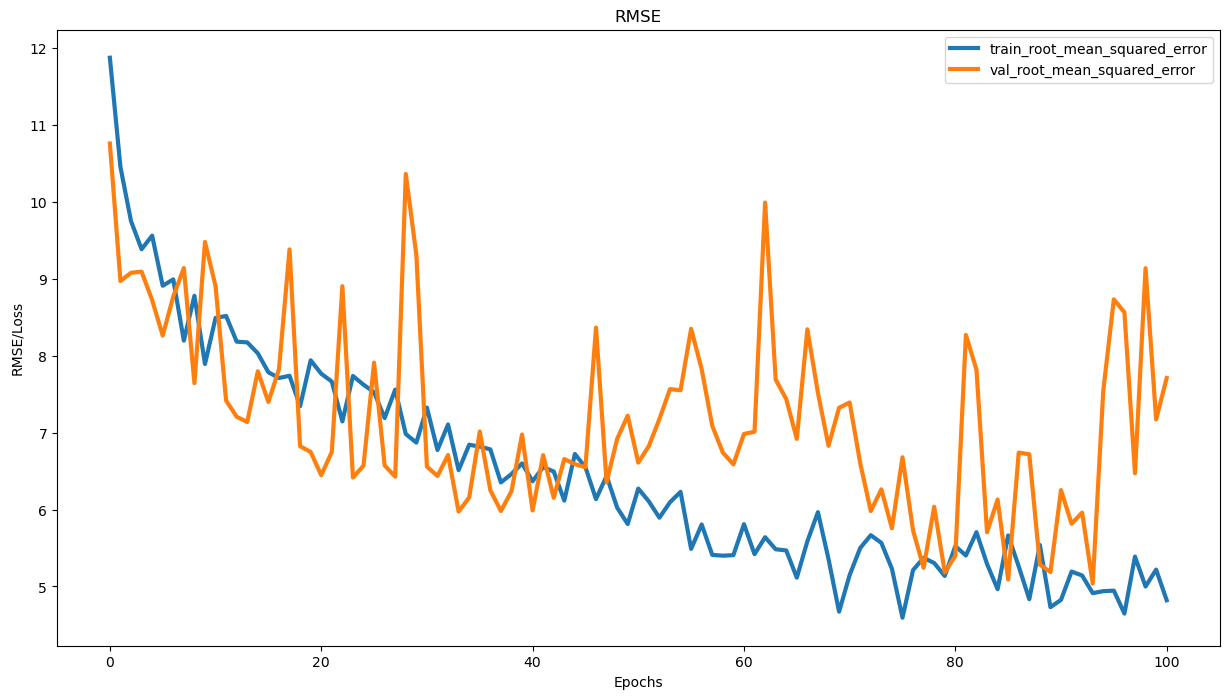

In [67]:
plot_measures_regression(model_name="MNIST-MODEL", history=history, title="RMSE",accuracy_measures_to_plot=["train_root_mean_squared_error", "val_root_mean_squared_error"])

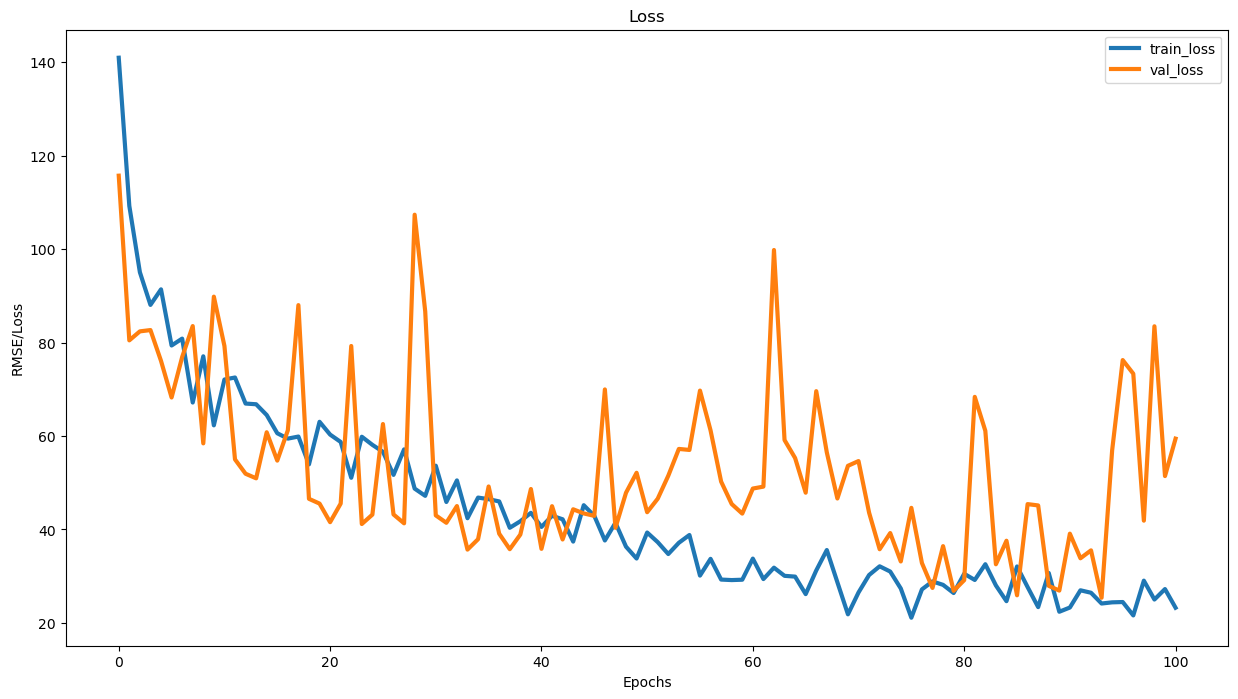

In [68]:
plot_measures_regression(model_name="BOSTON-HOUSING-MODEL", history=history, title="Loss", accuracy_measures_to_plot=["train_loss", "val_loss"])

> Die Ergebnisse sind nicht so gut wie man eventuell erwartet hätte, ich denke dies liegt hauptsächlich daran, dass sehr wenig Daten vorhanden sind, darum performt das Modell auf dem Validierungs-Datensatz ebenfalls ziemlich schlecht. In den Plots entstehen jedoch keine grossen Diskrepanzen und es sieht so aus als würde das Modell gut verallgemeinern (da es auf dem Validierungsdatensatz ähnlich performt). Mehr Daten könnten helfen bessere Ergebnisse zu erzielen, ohne das Modell komplett zu overfitten.

> Im Vergleich zum MNIST unterscheidet sich dieses Modell vor allem beim Input- und Output Layer. Hier werden nur 13 Inputs und 1 Output eingesetzt, da es 13 features gibt und man möchte am Ende einen kontinuierlichen Wert. Ausserdem sind die Metriken auf welche das Modell trainiert wird anders, da es sich schlussendlich um eine Regression und keine Klassifikation handelt.

---

## Referenzen

- Code Snippets/Informationen aus Kurs CDS-108: https://moodle.fhgr.ch/course/view.php?id=14551
- Tensorflow/Keras Doku: https://www.tensorflow.org/datasets/keras_example
- Hidden Layers: https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3
- Batches: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
- Batch and Epoch: https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
- Batch Size: https://stackoverflow.com/questions/35050753/how-big-should-batch-size-and-number-of-epochs-be-when-fitting-a-model#:~:text=Generally%20batch%20size%20of%2032,have%20worked%20fine%20for%20me.
- Activation Function: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/
- Regularization: https://towardsdatascience.com/regularization-techniques-for-neural-networks-379f5b4c9ac3
- Optimizer: https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
- Optimizer wählen: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
- Best optimizer MNIST: https://towardsdatascience.com/neural-network-optimization-algorithms-1a44c282f61d#:~:text=We%20compared%20different%20optimizers%20used,on%20MNIST%20data%20in%20TensorFlow.
- Boston Housing: https://www.kaggle.com/code/manishkc06/build-your-first-deep-learning-model

---